<a href="https://colab.research.google.com/github/saimani5/Notebooks_for_papers/blob/main/Hyperparameter_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q jaxlib==0.4.4+cuda11.cudnn82 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install -q gdown==4.5.4 atomai==0.7.4 gpax Kornia==0.6.8 jax==0.4.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 MB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.4/147.4 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.4/83.4 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 551.1/551.1 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 48.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.9/37.9 MB 11.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 kB 20.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.1/74.1 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 5.2 MB/s eta

In [2]:
import atomai as aoi
import kornia as K
import cv2
import torch
import torch.nn as nn
tt = torch.tensor
import numpy as np
import matplotlib.pyplot as plt

# Importing the packages
import gpax
import jax.numpy as jnp
gpax.utils.enable_x64()
import pickle

import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 3

In [ ]:
import jax
print(jax.__version__)
import jaxlib
print(jaxlib.__version__)

0.4.7
0.4.7


In [ ]:
!nvidia-smi

Thu Oct 12 10:06:14 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.199.02   Driver Version: 470.199.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:04:00.0 Off |                    0 |
| N/A   41C    P0    62W / 300W |  62157MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Download the cards dataset
!gdown https://drive.google.com/uc?id=1AyGHVflbIjzinkKBURHNVDx1wWg9JixB
!unzip cards.zip

Downloading...
From: https://drive.google.com/uc?id=1AyGHVflbIjzinkKBURHNVDx1wWg9JixB
To: /content/cards.zip
100% 30.2k/30.2k [00:00<00:00, 68.1MB/s]
Archive:  cards.zip
   creating: cards/
  inflating: cards/card4.JPG         
  inflating: cards/card1.JPG         
  inflating: cards/card2.JPG         
  inflating: cards/card3.JPG         


In [4]:
#@title Helper function and downloading the dataset
rs = lambda x: cv2.resize(x, (64, 64), cv2.INTER_CUBIC)

def get_data():
    card1 = rs(cv2.imread("cards/card1.JPG", cv2.IMREAD_GRAYSCALE))
    card2 = rs(cv2.imread("cards/card2.JPG", cv2.IMREAD_GRAYSCALE))
    card3 = rs(cv2.imread("cards/card3.JPG", cv2.IMREAD_GRAYSCALE))
    card4 = rs(cv2.imread("cards/card4.JPG", cv2.IMREAD_GRAYSCALE))
    card1 = tt(1 - card1 / card1.max())
    card2 = tt(1 - card2 / card2.max())
    card3 = tt(1 - card3 / card3.max())
    card4 = tt(1 - card4 / card4.max())
    return card1, card2, card3, card4


import math
def transform_imgs(cards, **kwargs):
    np.random.seed(0)
    torch.manual_seed(0)

    a = kwargs.get("angle")
    t = kwargs.get("translation")
    s = (kwargs.get("shear"))
    if s is not None:
        s = math.radians(s)


    n_samples = kwargs.get("samples", 3000)
    n_samples_total = n_samples*4

    card1 = K.geometry.transform.resize(cards[0], (45,45), interpolation='bilinear')
    card2 = K.geometry.transform.resize(cards[1], (45,45), interpolation='bilinear')
    card3 = K.geometry.transform.resize(cards[2], (45,45), interpolation='bilinear')
    card4 = K.geometry.transform.resize(cards[3], (45,45), interpolation='bilinear')

    card1 = card1[None, None].repeat_interleave(n_samples, dim = 0)
    card2 = card2[None, None].repeat_interleave(n_samples, dim = 0)
    card3 = card3[None, None].repeat_interleave(n_samples, dim = 0)
    card4 = card4[None, None].repeat_interleave(n_samples, dim = 0)

    cards_all = torch.cat((card1, card2, card3, card4), dim = 0)

    angles = tt(np.random.uniform(low = -a, high = a, size = [n_samples_total]))
    translations = tt(np.random.uniform(low = -t, high = t, size = [n_samples_total,1])).repeat_interleave(2, dim = 1)
    shears = tt(np.random.uniform(low = -s, high = s, size = [n_samples_total, 1])).repeat_interleave(2, dim = 1)

    transform = nn.Sequential(
        K.augmentation.CenterCrop((30, 30)),
        K.geometry.Affine(angle = angles, translation = translations,
                          shear = shears)
    )

    cards = transform(cards_all).squeeze().float()
    labels = torch.cat([torch.zeros(len(card1)), torch.ones(len(card2)),
                           2*torch.ones(len(card3)), 3*torch.ones(len(card4))])
    return cards, labels, angles, translations, shears


def plot_manifolds(model):
    fig, axes = plt.subplots(2, 2, figsize=(12, 12),
                            subplot_kw={'xticks':[], 'yticks':[]},
                            gridspec_kw=dict(hspace=0.1, wspace=0.05))
    for i, ax in enumerate(axes.flat):
        manifold = model.manifold2d(d=9, label=i, plot=False)
        grid = make_grid(manifold[:, None], nrow=9, pad_value=.5)
        ax.imshow(grid[0], cmap='viridis')
    plt.show()

In [ ]:
cards = get_data()
cards_all, labels_all, angles_all, translations_all, shears_all = transform_imgs(cards,
                                                                                angle = 120,
                                                                                translation = 0.1,
                                                                                shear = 20,
                                                                                samples = 2000)

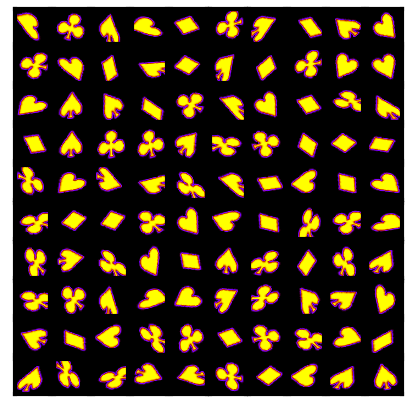

In [ ]:
# Plotting random images
np.random.seed(1)  # fix seed so that we get the same samples displayed at every run
fig, axes = plt.subplots(10, 10, figsize=(5, 5),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax in axes.flat:
    i = np.random.randint(len(cards_all))
    ax.imshow(cards_all[i], cmap='gnuplot', interpolation='bilinear')

# kernel Experimentation

## Clubs

In [ ]:
X = np.asarray(cards_all).reshape([-1, 900])

### RBF kernel

100%|█| 1000/1000 [03:57<00:00,  4.21it/s, init loss: 69238.9800, avg. loss [951



Inferred GP kernel parameters
k_length         [2.2259 1.4264]
k_scale          0.31220000000000003
noise            0.0081


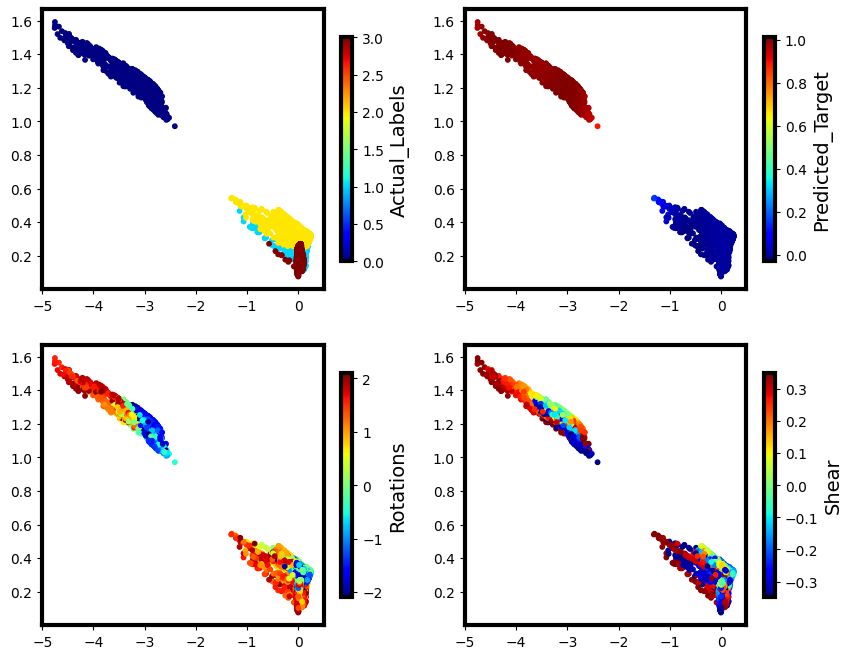

In [ ]:

X0 = np.copy(X)
targets0 = np.zeros(len(labels_all))
targets0[labels_all == 0] = 1

rng_key_0, rng_key_predict_0 = gpax.utils.get_keys()
dkl_0 = gpax.viDKL(900, 2, 'RBF')
dkl_0.fit(rng_key_0, X0, targets0)


embeded_0 = dkl_0.embed(X0)
pred_mean0, pred_var0 = dkl_0.predict_in_batches(rng_key_predict_0, X0, batch_size=250)
pred_std0 = jnp.sqrt(pred_var0)

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10,8))


im = ax[0,0].scatter(embeded_0[:, 1], embeded_0[:, 0], s=10, c = labels_all, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,0], shrink=.8)
cbar.set_label("Actual_Labels", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,1].scatter(embeded_0[:, 1], embeded_0[:, 0], s=10, c = pred_mean0, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,1], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,0].scatter(embeded_0[:, 1], embeded_0[:, 0], s=10, c = torch.deg2rad(angles_all),
                     cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,0], shrink=.8)
cbar.set_label("Rotations", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,1].scatter(embeded_0[:, 1], embeded_0[:, 0], s=10, c = shears_all[:,0], cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,1], shrink=.8)
cbar.set_label("Shear", fontsize=14)
cbar.ax.tick_params(labelsize=10)

### Matern kernel

100%|█| 1000/1000 [04:01<00:00,  4.13it/s, init loss: 69343.1835, avg. loss [951



Inferred GP kernel parameters
k_length         [2.5307 1.6623]
k_scale          0.3259
noise            0.0081


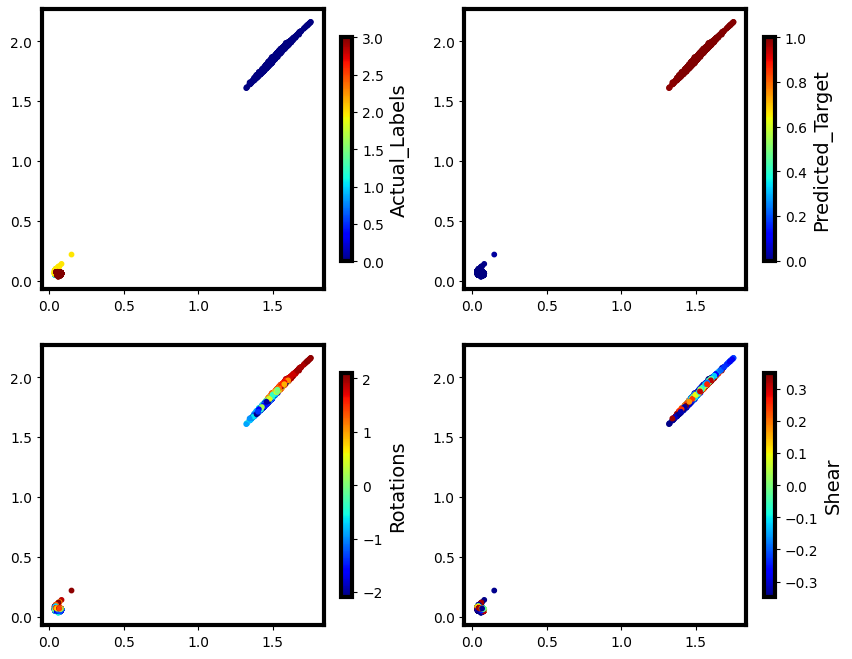

In [ ]:
# Experimenting with Matern Kernel
X0M = np.copy(X)
targets0M = np.zeros(len(labels_all))
targets0M[labels_all == 0] = 1

rng_key_0M, rng_key_predict_0M = gpax.utils.get_keys()
dkl_0M = gpax.viDKL(900, 2, 'Matern')
dkl_0M.fit(rng_key_0M, X0M, targets0M)

embeded_0M = dkl_0M.embed(X0M)
pred_mean0M, pred_var0M = dkl_0M.predict_in_batches(rng_key_predict_0M, X0M, batch_size=250)
pred_std0M = jnp.sqrt(pred_var0M)

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10,8))


im = ax[0,0].scatter(embeded_0M[:, 1], embeded_0M[:, 0], s=10, c = labels_all, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,0], shrink=.8)
cbar.set_label("Actual_Labels", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,1].scatter(embeded_0M[:, 1], embeded_0M[:, 0], s=10, c = pred_mean0M, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,1], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,0].scatter(embeded_0M[:, 1], embeded_0M[:, 0], s=10, c = torch.deg2rad(angles_all),
                     cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,0], shrink=.8)
cbar.set_label("Rotations", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,1].scatter(embeded_0M[:, 1], embeded_0M[:, 0], s=10, c = shears_all[:,0], cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,1], shrink=.8)
cbar.set_label("Shear", fontsize=14)
cbar.ax.tick_params(labelsize=10)

### Periodic kernel

100%|█| 1000/1000 [04:09<00:00,  4.00it/s, init loss: 67891.0897, avg. loss [951



Inferred GP kernel parameters
k_length         [5.7325 4.7357]
k_scale          0.0784
period           0.9488000000000001
noise            0.1875


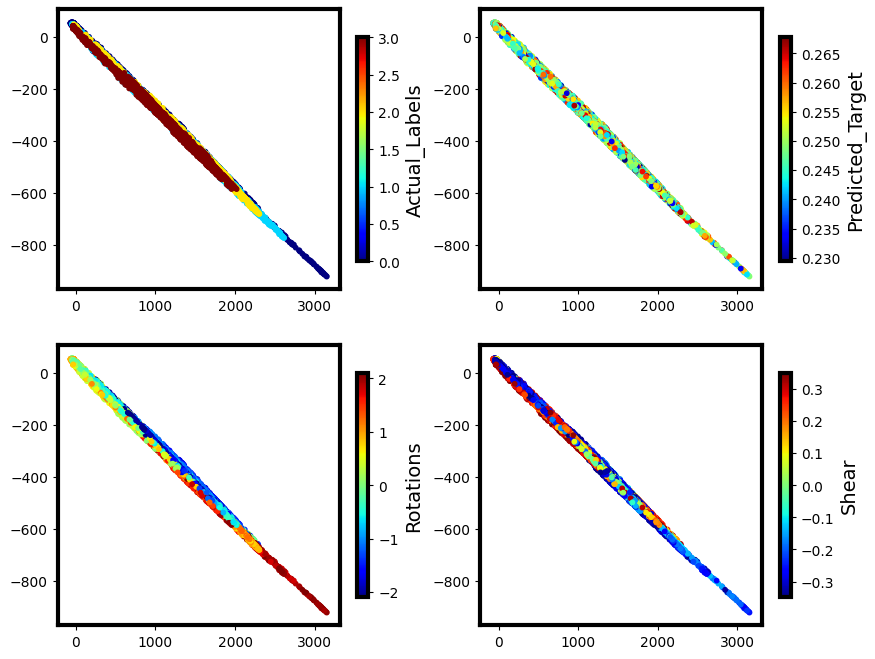

In [ ]:
# Experimenting with Periodic Kernel
X0P = np.copy(X)
targets0P = np.zeros(len(labels_all))
targets0P[labels_all == 0] = 1

rng_key_0P, rng_key_predict_0P = gpax.utils.get_keys()
dkl_0P = gpax.viDKL(900, 2, 'Periodic')
dkl_0P.fit(rng_key_0P, X0P, targets0P)

embeded_0P = dkl_0P.embed(X0P)
pred_mean0P, pred_var0P = dkl_0P.predict_in_batches(rng_key_predict_0P, X0P, batch_size=250)
pred_std0P = jnp.sqrt(pred_var0P)

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10,8))


im = ax[0,0].scatter(embeded_0P[:, 1], embeded_0P[:, 0], s=10, c = labels_all, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,0], shrink=.8)
cbar.set_label("Actual_Labels", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,1].scatter(embeded_0P[:, 1], embeded_0P[:, 0], s=10, c = pred_mean0P, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,1], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,0].scatter(embeded_0P[:, 1], embeded_0P[:, 0], s=10, c = torch.deg2rad(angles_all),
                     cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,0], shrink=.8)
cbar.set_label("Rotations", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,1].scatter(embeded_0P[:, 1], embeded_0P[:, 0], s=10, c = shears_all[:,0], cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,1], shrink=.8)
cbar.set_label("Shear", fontsize=14)
cbar.ax.tick_params(labelsize=10)

## All Suits

### RBF kernel

100%|█| 1000/1000 [03:55<00:00,  4.24it/s, init loss: 72172.6567, avg. loss [951



Inferred GP kernel parameters
k_length         [4.5082 4.3174]
k_scale          0.8136
noise            0.0088


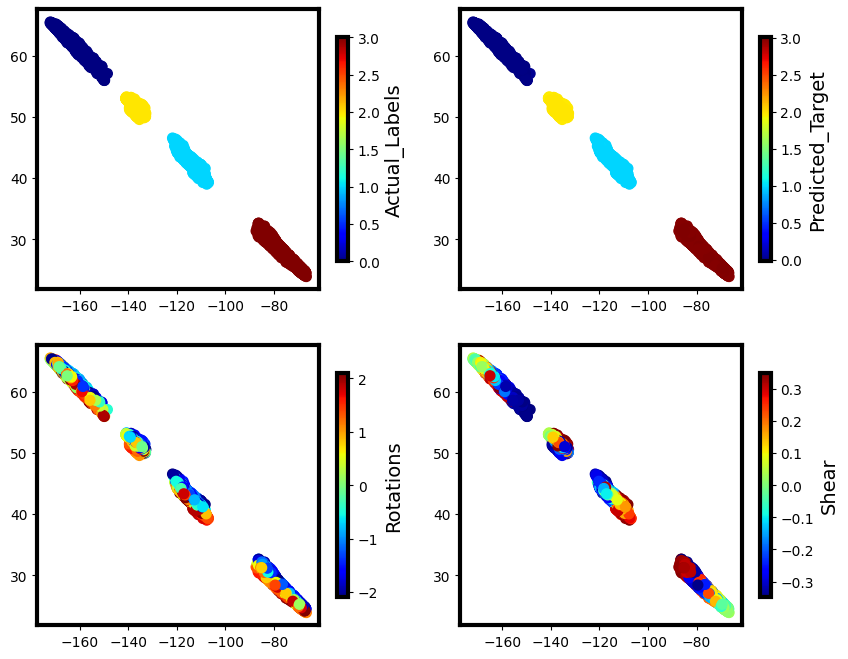

In [ ]:
X4 = np.copy(X)
targets4 = np.copy((labels_all))

rng_key_4, rng_key_predict_4 = gpax.utils.get_keys()
dkl_4 = gpax.viDKL(900, 2, 'RBF')
dkl_4.fit(rng_key_4, X, targets4)

embeded_4 = dkl_4.embed(X)
pred_mean4, pred_var4 = dkl_4.predict_in_batches(rng_key_predict_4, X, batch_size=250)
pred_std4 = jnp.sqrt(pred_var4)

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10,8))

im = ax[0,0].scatter(embeded_4[:, 1], embeded_4[:, 0], s=50, c = labels_all, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,0], shrink=.8)
cbar.set_label("Actual_Labels", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,1].scatter(embeded_4[:, 1], embeded_4[:, 0], s=50, c = pred_mean4, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,1], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,0].scatter(embeded_4[:, 1], embeded_4[:, 0], s=50, c = torch.deg2rad(angles_all),
                     cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,0], shrink=.8)
cbar.set_label("Rotations", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,1].scatter(embeded_4[:, 1], embeded_4[:, 0], s=50, c = shears_all[:,0], cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,1], shrink=.8)
cbar.set_label("Shear", fontsize=14)
cbar.ax.tick_params(labelsize=10)

### Matern kernel

100%|█| 1000/1000 [03:59<00:00,  4.17it/s, init loss: 72199.4071, avg. loss [951



Inferred GP kernel parameters
k_length         [2.9462 2.2926]
k_scale          0.9169
noise            0.0105


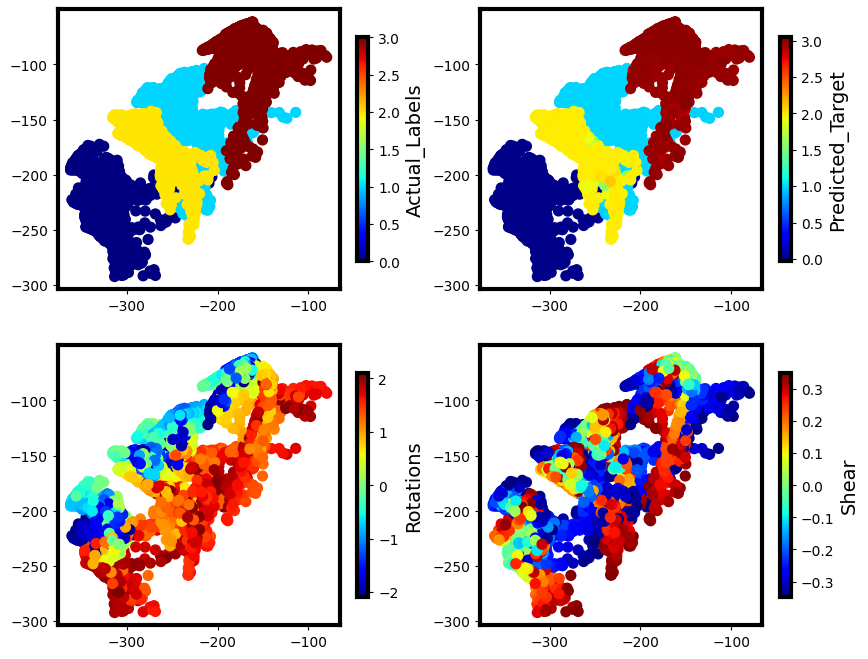

In [ ]:
X4M = np.copy(X)
targets4M = np.copy((labels_all))

rng_key_4M, rng_key_predict_4M = gpax.utils.get_keys()
dkl_4M = gpax.viDKL(900, 2, 'Matern')
dkl_4M.fit(rng_key_4M, X4M, targets4M)

embeded_4M = dkl_4M.embed(X4M)
pred_mean4M, pred_var4M = dkl_4M.predict_in_batches(rng_key_predict_4M, X4M, batch_size=250)
pred_std4M = jnp.sqrt(pred_var4M)

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10,8))

im = ax[0,0].scatter(embeded_4M[:, 1], embeded_4M[:, 0], s=50, c = labels_all, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,0], shrink=.8)
cbar.set_label("Actual_Labels", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,1].scatter(embeded_4M[:, 1], embeded_4M[:, 0], s=50, c = pred_mean4M, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,1], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,0].scatter(embeded_4M[:, 1], embeded_4M[:, 0], s=50, c = torch.deg2rad(angles_all),
                     cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,0], shrink=.8)
cbar.set_label("Rotations", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,1].scatter(embeded_4M[:, 1], embeded_4M[:, 0], s=50, c = shears_all[:,0], cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,1], shrink=.8)
cbar.set_label("Shear", fontsize=14)
cbar.ax.tick_params(labelsize=10)

### Periodic kernel

100%|█| 1000/1000 [04:06<00:00,  4.05it/s, init loss: 72641.2325, avg. loss [951



Inferred GP kernel parameters
k_length         [5.3279 4.5899]
k_scale          0.379
period           1.2541
noise            1.2493


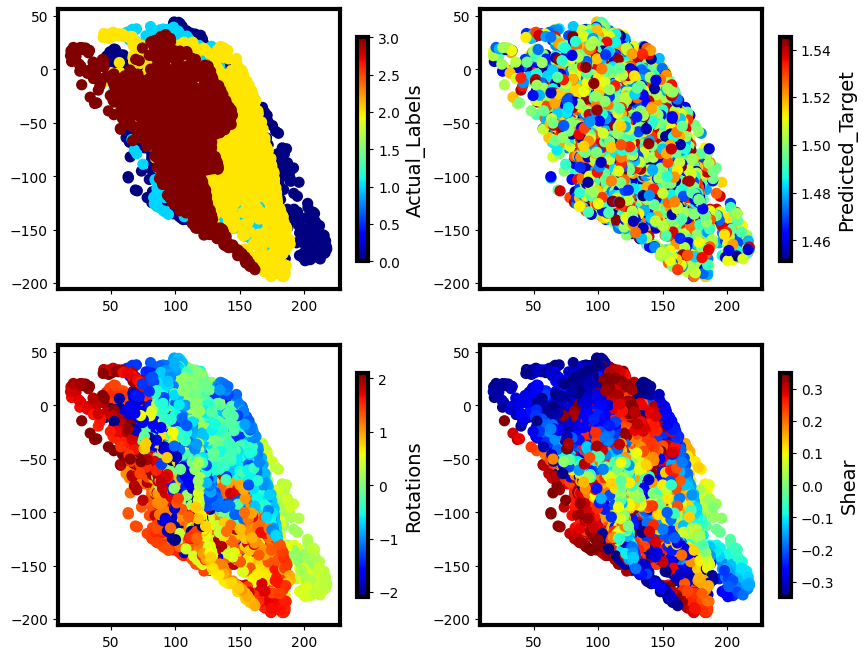

In [ ]:
X4P = np.copy(X)
targets4P = np.copy((labels_all))

rng_key_4P, rng_key_predict_4P = gpax.utils.get_keys()
dkl_4P = gpax.viDKL(900, 2, 'Periodic')
dkl_4P.fit(rng_key_4P, X4P, targets4P)

embeded_4P = dkl_4P.embed(X4P)
pred_mean4P, pred_var4P = dkl_4P.predict_in_batches(rng_key_predict_4P, X4P, batch_size=250)
pred_std4P = jnp.sqrt(pred_var4P)

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10,8))

im = ax[0,0].scatter(embeded_4P[:, 1], embeded_4P[:, 0], s=50, c = labels_all, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,0], shrink=.8)
cbar.set_label("Actual_Labels", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,1].scatter(embeded_4P[:, 1], embeded_4P[:, 0], s=50, c = pred_mean4P, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,1], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,0].scatter(embeded_4P[:, 1], embeded_4P[:, 0], s=50, c = torch.deg2rad(angles_all),
                     cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,0], shrink=.8)
cbar.set_label("Rotations", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,1].scatter(embeded_4P[:, 1], embeded_4P[:, 0], s=50, c = shears_all[:,0], cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,1], shrink=.8)
cbar.set_label("Shear", fontsize=14)
cbar.ax.tick_params(labelsize=10)

## Shear

### RBF kernel

100%|█| 1000/1000 [03:57<00:00,  4.22it/s, init loss: 68841.5697, avg. loss [951



Inferred GP kernel parameters
k_length         [3.4036 3.7282]
k_scale          0.18330000000000002
noise            0.0083


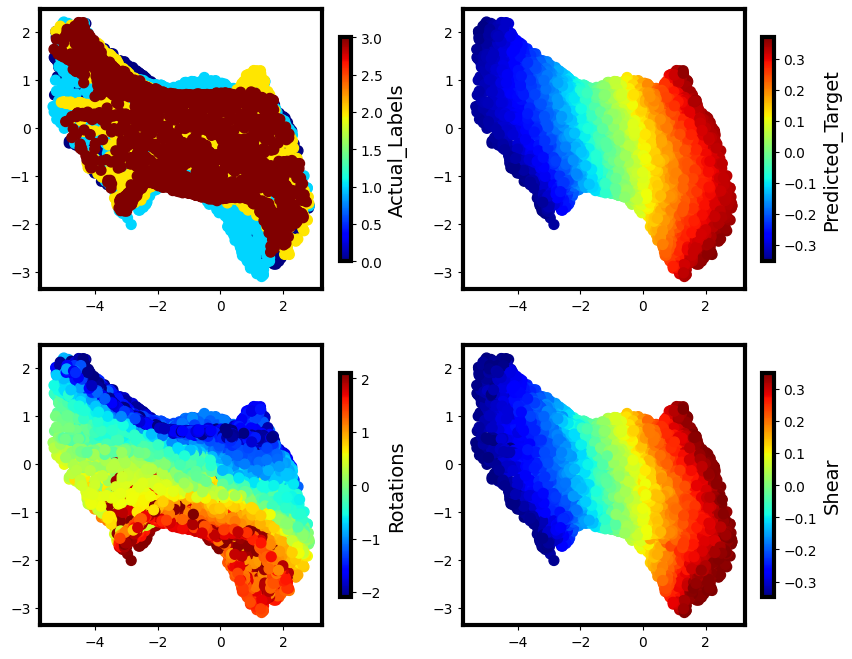

In [ ]:
X5 = np.copy(X)
targets5 = np.copy(shears_all[:,0])

rng_key_5, rng_key_predict_5 = gpax.utils.get_keys()
dkl_5 = gpax.viDKL(900, 2, 'RBF')
dkl_5.fit(rng_key_5, X5, targets5)

embeded_5 = dkl_5.embed(X5)
pred_mean5, pred_var5 = dkl_5.predict_in_batches(rng_key_predict_5, X5, batch_size=250)
pred_std5 = jnp.sqrt(pred_var5)

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10,8))

im = ax[0,0].scatter(embeded_5[:, 1], embeded_5[:, 0], s=50, c = labels_all, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,0], shrink=.8)
cbar.set_label("Actual_Labels", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,1].scatter(embeded_5[:, 1], embeded_5[:, 0], s=50, c = pred_mean5, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,1], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,0].scatter(embeded_5[:, 1], embeded_5[:, 0], s=50, c = torch.deg2rad(angles_all),
                     cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,0], shrink=.8)
cbar.set_label("Rotations", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,1].scatter(embeded_5[:, 1], embeded_5[:, 0], s=50, c = shears_all[:,0], cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,1], shrink=.8)
cbar.set_label("Shear", fontsize=14)
cbar.ax.tick_params(labelsize=10)

### Matern kernel

100%|█| 1000/1000 [04:02<00:00,  4.12it/s, init loss: 68955.2256, avg. loss [951



Inferred GP kernel parameters
k_length         [6.0814 3.9567]
k_scale          0.1864
noise            0.0083


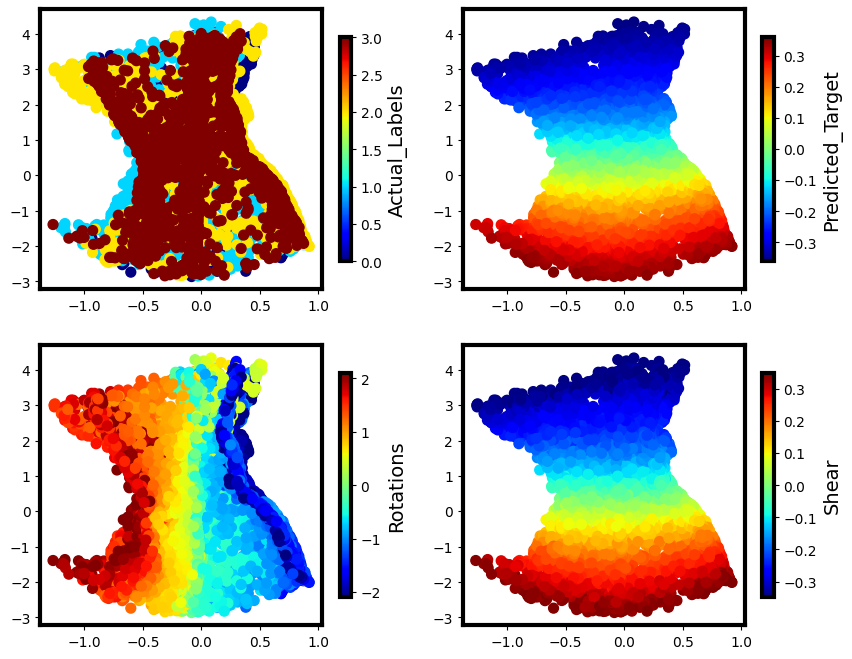

In [ ]:
X5M = np.copy(X)
targets5M = np.copy(shears_all[:,0])

rng_key_5M, rng_key_predict_5M = gpax.utils.get_keys()
dkl_5M = gpax.viDKL(900, 2, 'Matern')
dkl_5M.fit(rng_key_5M, X5M, targets5M)

embeded_5M = dkl_5M.embed(X5M)
pred_mean5M, pred_var5M = dkl_5M.predict_in_batches(rng_key_predict_5M, X5M, batch_size=250)
pred_std5M = jnp.sqrt(pred_var5M)

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10,8))

im = ax[0,0].scatter(embeded_5M[:, 1], embeded_5M[:, 0], s=50, c = labels_all, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,0], shrink=.8)
cbar.set_label("Actual_Labels", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,1].scatter(embeded_5M[:, 1], embeded_5M[:, 0], s=50, c = pred_mean5M, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,1], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,0].scatter(embeded_5M[:, 1], embeded_5M[:, 0], s=50, c = torch.deg2rad(angles_all),
                     cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,0], shrink=.8)
cbar.set_label("Rotations", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,1].scatter(embeded_5M[:, 1], embeded_5M[:, 0], s=50, c = shears_all[:,0], cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,1], shrink=.8)
cbar.set_label("Shear", fontsize=14)
cbar.ax.tick_params(labelsize=10)

### Periodic kernel

100%|█| 1000/1000 [04:10<00:00,  4.00it/s, init loss: 67240.4847, avg. loss [951



Inferred GP kernel parameters
k_length         [0.9107 1.4633]
k_scale          0.21680000000000002
period           2.1944
noise            0.006500000000000001


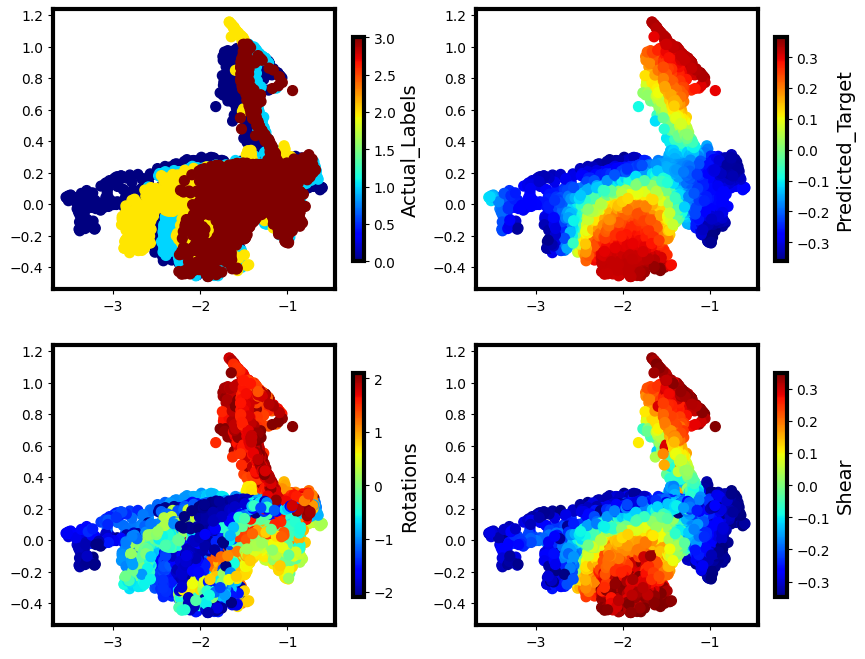

In [ ]:
X5P = np.copy(X)
targets5P = np.copy(shears_all[:,0])

rng_key_5P, rng_key_predict_5P = gpax.utils.get_keys()
dkl_5P = gpax.viDKL(900, 2, 'Periodic')
dkl_5P.fit(rng_key_5P, X5P, targets5P)

embeded_5P = dkl_5P.embed(X5P)
pred_mean5P, pred_var5P = dkl_5P.predict_in_batches(rng_key_predict_5P, X5P, batch_size=250)
pred_std5P = jnp.sqrt(pred_var5P)

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10,8))

im = ax[0,0].scatter(embeded_5P[:, 1], embeded_5P[:, 0], s=50, c = labels_all, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,0], shrink=.8)
cbar.set_label("Actual_Labels", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,1].scatter(embeded_5P[:, 1], embeded_5P[:, 0], s=50, c = pred_mean5P, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,1], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,0].scatter(embeded_5P[:, 1], embeded_5P[:, 0], s=50, c = torch.deg2rad(angles_all),
                     cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,0], shrink=.8)
cbar.set_label("Rotations", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,1].scatter(embeded_5P[:, 1], embeded_5P[:, 0], s=50, c = shears_all[:,0], cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,1], shrink=.8)
cbar.set_label("Shear", fontsize=14)
cbar.ax.tick_params(labelsize=10)

## Rotations

### RBF kernel

100%|█| 1000/1000 [03:58<00:00,  4.19it/s, init loss: 12825723.0869, avg. loss [



Inferred GP kernel parameters
k_length         [2.2283 1.6184]
k_scale          1.8405
noise            1.4532


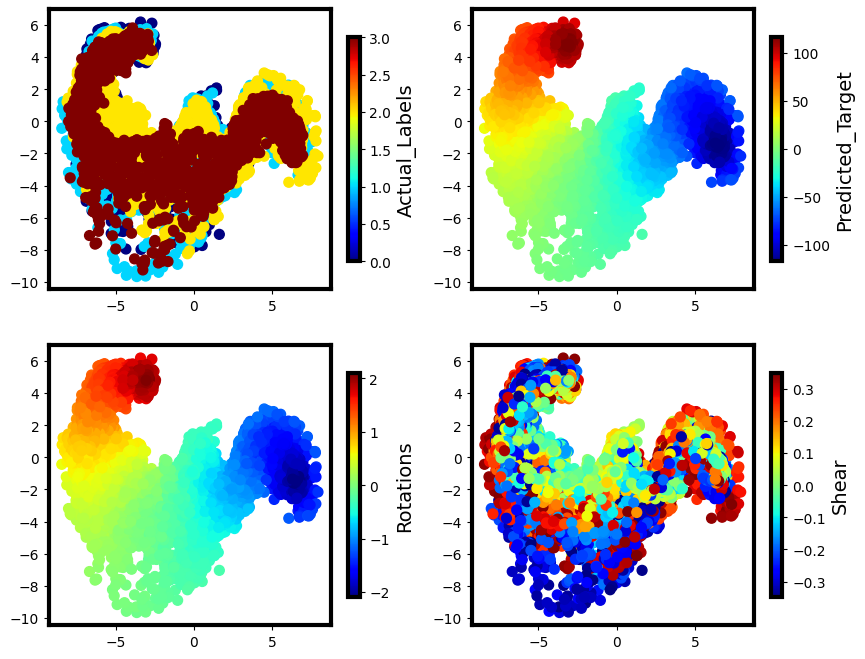

In [ ]:
X6 = np.copy(X)
targets6 = np.copy(angles_all)

rng_key_6, rng_key_predict_6 = gpax.utils.get_keys()
dkl_6 = gpax.viDKL(900, 2, 'RBF')
dkl_6.fit(rng_key_6, X, targets6)

embeded_6 = dkl_6.embed(X)
pred_mean6, pred_var6 = dkl_6.predict_in_batches(rng_key_predict_6, X, batch_size=250)
pred_std6 = jnp.sqrt(pred_var6)

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10,8))

im = ax[0,0].scatter(embeded_6[:, 1], embeded_6[:, 0], s=50, c = labels_all, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,0], shrink=.8)
cbar.set_label("Actual_Labels", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,1].scatter(embeded_6[:, 1], embeded_6[:, 0], s=50, c = pred_mean6, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,1], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,0].scatter(embeded_6[:, 1], embeded_6[:, 0], s=50, c = torch.deg2rad(angles_all),
                     cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,0], shrink=.8)
cbar.set_label("Rotations", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,1].scatter(embeded_6[:, 1], embeded_6[:, 0], s=50, c = shears_all[:,0], cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,1], shrink=.8)
cbar.set_label("Shear", fontsize=14)
cbar.ax.tick_params(labelsize=10)

### Matern kernel

100%|█| 1000/1000 [04:02<00:00,  4.12it/s, init loss: 12504400.2846, avg. loss [



Inferred GP kernel parameters
k_length         [2.4542 1.7484]
k_scale          1.7774
noise            1.5094


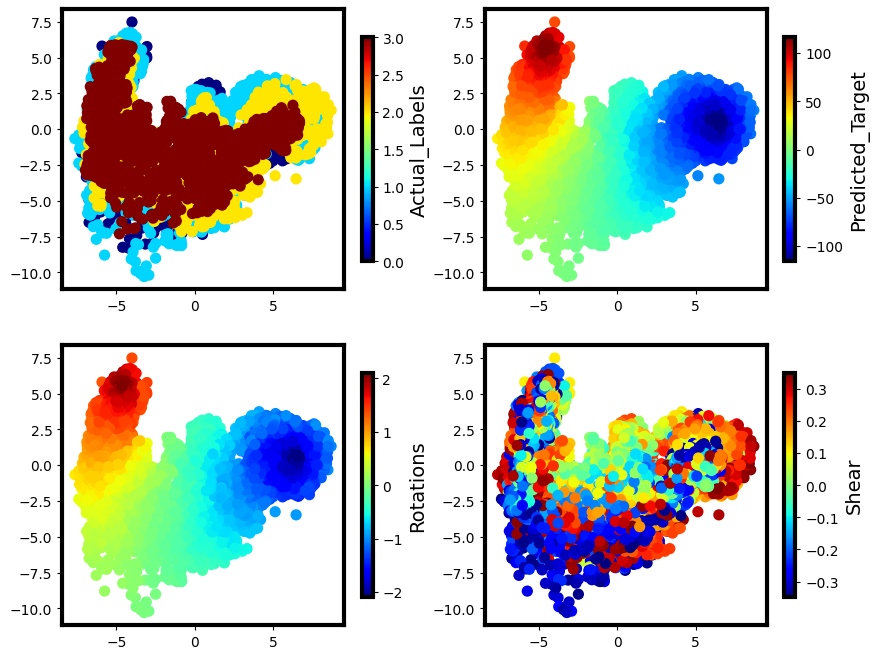

In [ ]:
X6M = np.copy(X)
targets6M = np.copy(angles_all)

rng_key_6M, rng_key_predict_6M = gpax.utils.get_keys()
dkl_6M = gpax.viDKL(900, 2, 'Matern')
dkl_6M.fit(rng_key_6M, X6M, targets6M)

embeded_6M = dkl_6M.embed(X6M)
pred_mean6M, pred_var6M = dkl_6M.predict_in_batches(rng_key_predict_6M, X6M, batch_size=250)
pred_std6M = jnp.sqrt(pred_var6M)

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10,8))

im = ax[0,0].scatter(embeded_6M[:, 1], embeded_6M[:, 0], s=50, c = labels_all, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,0], shrink=.8)
cbar.set_label("Actual_Labels", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,1].scatter(embeded_6M[:, 1], embeded_6M[:, 0], s=50, c = pred_mean6M, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,1], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,0].scatter(embeded_6M[:, 1], embeded_6M[:, 0], s=50, c = torch.deg2rad(angles_all),
                     cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,0], shrink=.8)
cbar.set_label("Rotations", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,1].scatter(embeded_6M[:, 1], embeded_6M[:, 0], s=50, c = shears_all[:,0], cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,1], shrink=.8)
cbar.set_label("Shear", fontsize=14)
cbar.ax.tick_params(labelsize=10)

### Periodic kernel

100%|█| 1000/1000 [04:09<00:00,  4.01it/s, init loss: 21644169.7354, avg. loss [



Inferred GP kernel parameters
k_length         [0.0182 0.0125]
k_scale          202.78820000000002
period           1.7227000000000001
noise            2.9578


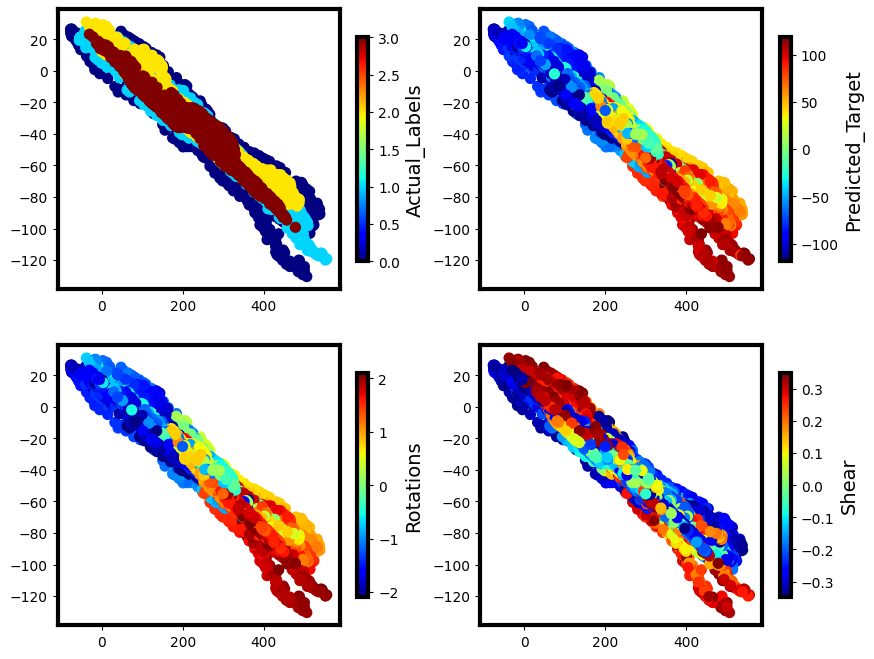

In [ ]:
X6P = np.copy(X)
targets6P = np.copy(angles_all)

rng_key_6P, rng_key_predict_6P = gpax.utils.get_keys()
dkl_6P = gpax.viDKL(900, 2, 'Periodic')
dkl_6P.fit(rng_key_6P, X6P, targets6P)

embeded_6P = dkl_6P.embed(X6P)
pred_mean6P, pred_var6P = dkl_6P.predict_in_batches(rng_key_predict_6P, X6P, batch_size=250)
pred_std6P = jnp.sqrt(pred_var6P)

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10,8))

im = ax[0,0].scatter(embeded_6P[:, 1], embeded_6P[:, 0], s=50, c = labels_all, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,0], shrink=.8)
cbar.set_label("Actual_Labels", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,1].scatter(embeded_6P[:, 1], embeded_6P[:, 0], s=50, c = pred_mean6P, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,1], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,0].scatter(embeded_6P[:, 1], embeded_6P[:, 0], s=50, c = torch.deg2rad(angles_all),
                     cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,0], shrink=.8)
cbar.set_label("Rotations", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,1].scatter(embeded_6P[:, 1], embeded_6P[:, 0], s=50, c = shears_all[:,0], cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,1], shrink=.8)
cbar.set_label("Shear", fontsize=14)
cbar.ax.tick_params(labelsize=10)

# DKL Encoder architecture

In [ ]:
import haiku as hk

class MLP2(hk.Module):
    """Simple MLP"""
    def __init__(self, embedim=2, neurons = 2):
        super().__init__()
        self._embedim = embedim
        self.neurons = neurons

    def __call__(self, x):
        x = hk.Linear(self.neurons)(x)
        x = jax.nn.relu(x)
        x = hk.Linear(self.neurons)(x)
        x = jax.nn.relu(x)
        x = hk.Linear(self._embedim)(x)
        return x

class MLP4(hk.Module):
    """Simple MLP"""
    def __init__(self, embedim=2, neurons = 4):
        super().__init__()
        self._embedim = embedim
        self.neurons = neurons

    def __call__(self, x):
        x = hk.Linear(self.neurons)(x)
        x = jax.nn.relu(x)
        x = hk.Linear(self.neurons)(x)
        x = jax.nn.relu(x)
        x = hk.Linear(self._embedim)(x)
        return x


class MLP8(hk.Module):
    """Simple MLP"""
    def __init__(self, embedim=2, neurons = 8):
        super().__init__()
        self._embedim = embedim
        self.neurons = neurons

    def __call__(self, x):
        x = hk.Linear(self.neurons)(x)
        x = jax.nn.relu(x)
        x = hk.Linear(self.neurons)(x)
        x = jax.nn.relu(x)
        x = hk.Linear(self._embedim)(x)
        return x

class MLP16(hk.Module):
    """Simple MLP"""
    def __init__(self, embedim=2, neurons = 16):
        super().__init__()
        self._embedim = embedim
        self.neurons = neurons

    def __call__(self, x):
        x = hk.Linear(self.neurons)(x)
        x = jax.nn.relu(x)
        x = hk.Linear(self.neurons)(x)
        x = jax.nn.relu(x)
        x = hk.Linear(self._embedim)(x)
        return x

class MLP32(hk.Module):
    """Simple MLP"""
    def __init__(self, embedim=2, neurons = 32):
        super().__init__()
        self._embedim = embedim
        self.neurons = neurons

    def __call__(self, x):
        x = hk.Linear(self.neurons)(x)
        x = jax.nn.relu(x)
        x = hk.Linear(self.neurons)(x)
        x = jax.nn.relu(x)
        x = hk.Linear(self._embedim)(x)
        return x

class MLP64(hk.Module):
    """Simple MLP"""
    def __init__(self, embedim=2, neurons = 64):
        super().__init__()
        self._embedim = embedim
        self.neurons = neurons

    def __call__(self, x):
        x = hk.Linear(self.neurons)(x)
        x = jax.nn.relu(x)
        x = hk.Linear(self.neurons)(x)
        x = jax.nn.relu(x)
        x = hk.Linear(self._embedim)(x)
        return x

class MLP128(hk.Module):
    """Simple MLP"""
    def __init__(self, embedim=2, neurons = 128):
        super().__init__()
        self._embedim = embedim
        self.neurons = neurons

    def __call__(self, x):
        x = hk.Linear(self.neurons)(x)
        x = jax.nn.relu(x)
        x = hk.Linear(self.neurons)(x)
        x = jax.nn.relu(x)
        x = hk.Linear(self._embedim)(x)
        return x


class MLP256(hk.Module):
    """Simple MLP"""
    def __init__(self, embedim=2, neurons = 256):
        super().__init__()
        self._embedim = embedim
        self.neurons = neurons

    def __call__(self, x):
        x = hk.Linear(self.neurons)(x)
        x = jax.nn.relu(x)
        x = hk.Linear(self.neurons)(x)
        x = jax.nn.relu(x)
        x = hk.Linear(self._embedim)(x)
        return x

## Cards dataset
Target function: Rotations

In [ ]:
X6 = np.copy(X)
np.random.seed(0)
idx6 = np.random.choice(np.arange(len(X6)), size = 100, replace = False)
X6_train = X6[idx6]
X6_unmeasured = np.delete(X6, idx6, axis=0)

indices_total_6 = np.arange(len(X))
indices_train_6 = indices_total_6[idx6]
y6_train = targets6[idx6]
indices_unmeasured_6 = np.delete(indices_total_6, idx6)

In [ ]:
seeds = [0, 100, 200, 300, 400]
networks = [MLP2, MLP4, MLP8, MLP16, MLP32, MLP64, MLP128, MLP256]
rmse_errors = []

for MLP in networks:
    error = np.zeros(3)
    for i in range(3):
        rng_key, rng_key_predict = gpax.utils.get_keys(seeds[i])
        dkl = gpax.viDKL(900, 2, 'RBF', nn = MLP)
        dkl.fit(rng_key, X6_train, y6_train)
        pred_mean, pred_var = dkl.predict_in_batches(rng_key_predict, X, batch_size=250)
        error[i] = np.sqrt(np.mean((np.array(pred_mean) - targets6)**2))
        if i == 2:
            rmse_errors.append(np.mean(error))


100%|█| 1000/1000 [00:01<00:00, 572.96it/s, init loss: 187554.4522, avg. loss [9



Inferred GP kernel parameters
k_length         [0.903  0.6194]
k_scale          11.0504
noise            4.7497


100%|█| 1000/1000 [00:01<00:00, 571.82it/s, init loss: 214184.7062, avg. loss [9



Inferred GP kernel parameters
k_length         [0.3937 0.4141]
k_scale          19.5344
noise            1.3291000000000002


100%|█| 1000/1000 [00:01<00:00, 573.87it/s, init loss: 248481.2211, avg. loss [9



Inferred GP kernel parameters
k_length         [0.7127 0.2383]
k_scale          3.7793
noise            6.884


100%|█| 1000/1000 [00:01<00:00, 566.58it/s, init loss: 212120.2661, avg. loss [9



Inferred GP kernel parameters
k_length         [0.9173 0.6844]
k_scale          9.9036
noise            1.4203000000000001


100%|█| 1000/1000 [00:01<00:00, 566.74it/s, init loss: 218907.4222, avg. loss [9



Inferred GP kernel parameters
k_length         [0.5556 0.4292]
k_scale          18.0048
noise            1.1177000000000001


100%|█| 1000/1000 [00:01<00:00, 562.91it/s, init loss: 234331.1604, avg. loss [9



Inferred GP kernel parameters
k_length         [0.8404 0.7996]
k_scale          10.745700000000001
noise            1.2769000000000001


100%|█| 1000/1000 [00:01<00:00, 564.35it/s, init loss: 147126.6618, avg. loss [9



Inferred GP kernel parameters
k_length         [1.0868 0.8508]
k_scale          9.1105
noise            1.5537


100%|█| 1000/1000 [00:01<00:00, 562.54it/s, init loss: 137869.8051, avg. loss [9



Inferred GP kernel parameters
k_length         [0.6088 0.7004]
k_scale          11.698500000000001
noise            1.0781


100%|█| 1000/1000 [00:01<00:00, 560.90it/s, init loss: 193407.9618, avg. loss [9



Inferred GP kernel parameters
k_length         [0.9058 0.8264]
k_scale          9.6327
noise            1.2432


100%|█| 1000/1000 [00:01<00:00, 564.26it/s, init loss: 174370.8895, avg. loss [9



Inferred GP kernel parameters
k_length         [1.178  0.7249]
k_scale          9.975900000000001
noise            2.5758


100%|█| 1000/1000 [00:01<00:00, 561.58it/s, init loss: 149199.1749, avg. loss [9



Inferred GP kernel parameters
k_length         [0.6455 0.6038]
k_scale          15.523700000000002
noise            1.5283


100%|█| 1000/1000 [00:02<00:00, 420.59it/s, init loss: 210817.7420, avg. loss [9



Inferred GP kernel parameters
k_length         [1.1926 1.0027]
k_scale          8.1752
noise            1.3227


100%|█| 1000/1000 [00:01<00:00, 548.21it/s, init loss: 177557.7208, avg. loss [9



Inferred GP kernel parameters
k_length         [1.4899 0.9784]
k_scale          10.1689
noise            4.0991


100%|█| 1000/1000 [00:01<00:00, 548.37it/s, init loss: 179074.4733, avg. loss [9



Inferred GP kernel parameters
k_length         [0.9881 0.6657]
k_scale          14.3506
noise            2.1088


100%|█| 1000/1000 [00:01<00:00, 546.47it/s, init loss: 198452.3439, avg. loss [9



Inferred GP kernel parameters
k_length         [1.2093 1.2066]
k_scale          8.8754
noise            2.7767


100%|█| 1000/1000 [00:01<00:00, 550.61it/s, init loss: 212154.1570, avg. loss [9



Inferred GP kernel parameters
k_length         [2.5559 1.6546]
k_scale          5.9321
noise            2.5378000000000003


100%|█| 1000/1000 [00:01<00:00, 550.03it/s, init loss: 187529.5623, avg. loss [9



Inferred GP kernel parameters
k_length         [1.6208 1.5536]
k_scale          11.3024
noise            3.6141


100%|█| 1000/1000 [00:01<00:00, 548.42it/s, init loss: 225488.0981, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7273 1.7071]
k_scale          9.3435
noise            3.317


100%|█| 1000/1000 [00:01<00:00, 545.39it/s, init loss: 266033.5929, avg. loss [9



Inferred GP kernel parameters
k_length         [5.8292 4.4919]
k_scale          7.8498
noise            7.96


100%|█| 1000/1000 [00:01<00:00, 544.91it/s, init loss: 252618.1895, avg. loss [9



Inferred GP kernel parameters
k_length         [0.7703 0.5972]
k_scale          16.5389
noise            9.974400000000001


100%|█| 1000/1000 [00:01<00:00, 526.95it/s, init loss: 274265.9017, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8348 2.0954]
k_scale          9.800600000000001
noise            10.3236


100%|█| 1000/1000 [00:01<00:00, 528.90it/s, init loss: 425540.0767, avg. loss [9



Inferred GP kernel parameters
k_length         [1.2199 0.8648]
k_scale          8.1647
noise            14.423200000000001


100%|█| 1000/1000 [00:01<00:00, 527.10it/s, init loss: 402991.2067, avg. loss [9



Inferred GP kernel parameters
k_length         [0.6317 0.5039]
k_scale          16.4315
noise            10.168000000000001


100%|█| 1000/1000 [00:01<00:00, 538.34it/s, init loss: 433148.4401, avg. loss [9



Inferred GP kernel parameters
k_length         [0.9093 0.8575]
k_scale          9.1224
noise            12.244800000000001


Text(0.5, 1.0, 'Cards initialization dataset, target: Rotations')

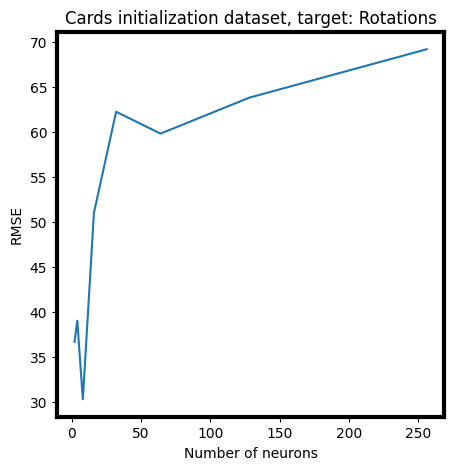

In [ ]:
fig, ax = plt.subplots(figsize = (5,5))
ax.plot([2,4,8,16,32,64,128,256], rmse_errors)
ax.set_xlabel('Number of neurons')
ax.set_ylabel('RMSE')
ax.set_title('Cards initialization dataset, target: Rotations')

## Cards dataset
Target function = Shears

In [ ]:
X5 = np.copy(X)
np.random.seed(0)
idx5 = np.random.choice(np.arange(len(X5)), size = 100, replace = False)
X5_train = X5[idx5]
X5_unmeasured = np.delete(X5, idx5, axis=0)

indices_total_5 = np.arange(len(X))
indices_train_5 = indices_total_5[idx5]
y5_train = targets5[idx5]
indices_unmeasured_5 = np.delete(indices_total_5, idx5)

In [ ]:
seeds = [0, 100, 200, 300, 400]
networks = [MLP2, MLP4, MLP8, MLP16, MLP32, MLP64, MLP128, MLP256]
rmse_errors = []

for MLP in networks:
    error = np.zeros(5)
    for i in range(5):
        rng_key, rng_key_predict = gpax.utils.get_keys(seeds[i])
        dkl = gpax.viDKL(900, 2, 'RBF', nn = MLP)
        dkl.fit(rng_key, X5_train, y5_train)
        pred_mean, pred_var = dkl.predict_in_batches(rng_key_predict, X, batch_size=250)
        error[i] = np.sqrt(np.mean((np.array(pred_mean) - targets5)**2))
        if i == 4:
            rmse_errors.append(np.mean(error))

100%|█| 1000/1000 [00:02<00:00, 432.66it/s, init loss: 1873.9673, avg. loss [951



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.22410000000000002
noise            0.0444


100%|█| 1000/1000 [00:01<00:00, 560.82it/s, init loss: 1852.5282, avg. loss [951



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.22690000000000002
noise            0.043000000000000003


100%|█| 1000/1000 [00:01<00:00, 562.45it/s, init loss: 1857.4453, avg. loss [951



Inferred GP kernel parameters
k_length         [0.3406 0.3679]
k_scale          0.2686
noise            0.0083


100%|█| 1000/1000 [00:01<00:00, 562.87it/s, init loss: 1893.2430, avg. loss [951



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.2242
noise            0.048600000000000004


100%|█| 1000/1000 [00:01<00:00, 567.54it/s, init loss: 1867.4171, avg. loss [951



Inferred GP kernel parameters
k_length         [0.3517 0.36  ]
k_scale          0.2978
noise            0.0066


100%|█| 1000/1000 [00:01<00:00, 567.08it/s, init loss: 3633.8736, avg. loss [951



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.22410000000000002
noise            0.0444


100%|█| 1000/1000 [00:01<00:00, 564.18it/s, init loss: 3634.7250, avg. loss [951



Inferred GP kernel parameters
k_length         [0.3143 0.3679]
k_scale          0.26680000000000004
noise            0.0067


100%|█| 1000/1000 [00:01<00:00, 565.25it/s, init loss: 3625.3131, avg. loss [951



Inferred GP kernel parameters
k_length         [0.368  0.3708]
k_scale          0.2561
noise            0.008


100%|█| 1000/1000 [00:01<00:00, 566.19it/s, init loss: 3660.5367, avg. loss [951



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.22440000000000002
noise            0.048600000000000004


100%|█| 1000/1000 [00:01<00:00, 566.93it/s, init loss: 3613.6756, avg. loss [951



Inferred GP kernel parameters
k_length         [0.3678 0.3838]
k_scale          0.27790000000000004
noise            0.0068000000000000005


100%|█| 1000/1000 [00:01<00:00, 564.80it/s, init loss: 7195.4531, avg. loss [951



Inferred GP kernel parameters
k_length         [0.4182 0.3665]
k_scale          0.2758
noise            0.0097


100%|█| 1000/1000 [00:01<00:00, 567.91it/s, init loss: 7183.0844, avg. loss [951



Inferred GP kernel parameters
k_length         [0.3685 0.3672]
k_scale          0.2631
noise            0.007


100%|█| 1000/1000 [00:01<00:00, 565.03it/s, init loss: 7179.3418, avg. loss [951



Inferred GP kernel parameters
k_length         [0.3427 0.3679]
k_scale          0.2893
noise            0.0078000000000000005


100%|█| 1000/1000 [00:01<00:00, 566.47it/s, init loss: 7212.8183, avg. loss [951



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.2245
noise            0.048600000000000004


100%|█| 1000/1000 [00:02<00:00, 436.92it/s, init loss: 7175.8230, avg. loss [951



Inferred GP kernel parameters
k_length         [0.378  0.3715]
k_scale          0.2642
noise            0.007200000000000001


100%|█| 1000/1000 [00:01<00:00, 565.51it/s, init loss: 14404.9995, avg. loss [95



Inferred GP kernel parameters
k_length         [0.3599 0.3622]
k_scale          0.25930000000000003
noise            0.009600000000000001


100%|█| 1000/1000 [00:01<00:00, 560.42it/s, init loss: 14385.5784, avg. loss [95



Inferred GP kernel parameters
k_length         [0.3791 0.3891]
k_scale          0.3047
noise            0.006500000000000001


100%|█| 1000/1000 [00:01<00:00, 562.43it/s, init loss: 14398.2245, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4093 0.4203]
k_scale          0.23620000000000002
noise            0.0085


100%|█| 1000/1000 [00:01<00:00, 561.95it/s, init loss: 14410.6129, avg. loss [95



Inferred GP kernel parameters
k_length         [0.3647 0.3679]
k_scale          0.27340000000000003
noise            0.015700000000000002


100%|█| 1000/1000 [00:01<00:00, 563.67it/s, init loss: 14400.2005, avg. loss [95



Inferred GP kernel parameters
k_length         [0.394  0.4179]
k_scale          0.26330000000000003
noise            0.007


100%|█| 1000/1000 [00:01<00:00, 551.15it/s, init loss: 29180.3621, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4515 0.4501]
k_scale          0.23820000000000002
noise            0.0099


100%|█| 1000/1000 [00:01<00:00, 557.02it/s, init loss: 29178.8542, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5959 0.6079]
k_scale          0.249
noise            0.0068000000000000005


100%|█| 1000/1000 [00:01<00:00, 561.64it/s, init loss: 29166.0107, avg. loss [95



Inferred GP kernel parameters
k_length         [0.3725 0.3624]
k_scale          0.2718
noise            0.008


100%|█| 1000/1000 [00:01<00:00, 557.37it/s, init loss: 29186.2192, avg. loss [95



Inferred GP kernel parameters
k_length         [0.3656 0.3191]
k_scale          0.2283
noise            0.016300000000000002


100%|█| 1000/1000 [00:01<00:00, 560.99it/s, init loss: 29128.0924, avg. loss [95



Inferred GP kernel parameters
k_length         [0.3957 0.386 ]
k_scale          0.2674
noise            0.007


100%|█| 1000/1000 [00:01<00:00, 559.67it/s, init loss: 60198.9135, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4439 0.3954]
k_scale          0.26990000000000003
noise            0.0091


100%|█| 1000/1000 [00:01<00:00, 556.63it/s, init loss: 60225.4749, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5363 0.5068]
k_scale          0.48710000000000003
noise            0.0055000000000000005


100%|█| 1000/1000 [00:02<00:00, 429.78it/s, init loss: 60236.1144, avg. loss [95



Inferred GP kernel parameters
k_length         [0.3879 0.4202]
k_scale          0.2827
noise            0.0078000000000000005


100%|█| 1000/1000 [00:01<00:00, 556.43it/s, init loss: 60278.8884, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4701 0.5522]
k_scale          0.2891
noise            0.0152


100%|█| 1000/1000 [00:01<00:00, 559.58it/s, init loss: 60216.0268, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4676 0.4877]
k_scale          0.3357
noise            0.006500000000000001


100%|█| 1000/1000 [00:01<00:00, 531.23it/s, init loss: 128262.6753, avg. loss [9



Inferred GP kernel parameters
k_length         [0.555  0.4634]
k_scale          0.2989
noise            0.008400000000000001


100%|█| 1000/1000 [00:01<00:00, 530.15it/s, init loss: 128202.4386, avg. loss [9



Inferred GP kernel parameters
k_length         [1.2157 1.2394]
k_scale          0.455
noise            0.0047


100%|█| 1000/1000 [00:01<00:00, 530.36it/s, init loss: 128237.0704, avg. loss [9



Inferred GP kernel parameters
k_length         [0.8336 1.005 ]
k_scale          0.2316
noise            0.0076


100%|█| 1000/1000 [00:01<00:00, 532.50it/s, init loss: 128253.8805, avg. loss [9



Inferred GP kernel parameters
k_length         [0.6409 0.7811]
k_scale          0.3007
noise            0.014100000000000001


100%|█| 1000/1000 [00:01<00:00, 532.64it/s, init loss: 128244.2715, avg. loss [9



Inferred GP kernel parameters
k_length         [0.8531 0.9027]
k_scale          0.5038
noise            0.0055000000000000005


100%|█| 1000/1000 [00:01<00:00, 528.11it/s, init loss: 288118.6671, avg. loss [9



Inferred GP kernel parameters
k_length         [1.3422 1.3684]
k_scale          0.2315
noise            0.0083


100%|█| 1000/1000 [00:01<00:00, 522.21it/s, init loss: 288115.3398, avg. loss [9



Inferred GP kernel parameters
k_length         [1.5683 1.9739]
k_scale          0.4268
noise            0.0044


100%|█| 1000/1000 [00:01<00:00, 516.16it/s, init loss: 288091.3499, avg. loss [9



Inferred GP kernel parameters
k_length         [1.5251 1.1301]
k_scale          0.2664
noise            0.0064


100%|█| 1000/1000 [00:01<00:00, 524.82it/s, init loss: 288092.0037, avg. loss [9



Inferred GP kernel parameters
k_length         [1.1287 1.1029]
k_scale          0.24980000000000002
noise            0.014


100%|█| 1000/1000 [00:01<00:00, 550.25it/s, init loss: 288088.8165, avg. loss [9



Inferred GP kernel parameters
k_length         [2.3282 3.2294]
k_scale          0.47040000000000004
noise            0.0048000000000000004


Text(0.5, 1.0, 'Cards initialization dataset, target: Shear(rad)')

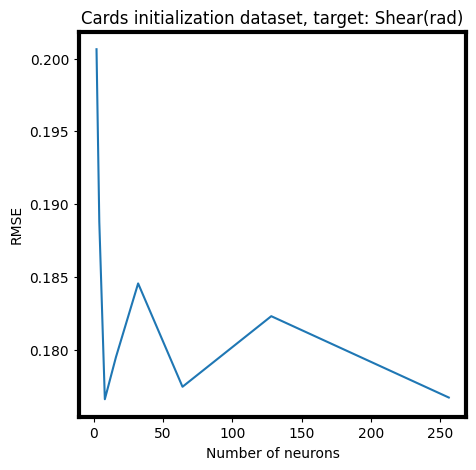

In [ ]:
fig, ax = plt.subplots(figsize = (5,5))
ax.plot([2,4,8,16,32,64,128,256], rmse_errors)
ax.set_xlabel('Number of neurons')
ax.set_ylabel('RMSE')
ax.set_title('Cards initialization dataset, target: Shear(rad)')

## FerroSIM dataset
Target function: curls

In [5]:
!gdown 11hfagD1JxdzYiZrXeU6nNUWnSF9ngUXu
!gdown 1vAVM_6MWbkw-WdWPMPZaL92y6Jtecr6R
!gdown 1wc5-92xsa6fdjF9n4I_8MH1xBjaZJfWm


dataset = np.load('dataset.npy')   # 7,500 electric fields, the generation of these will be discussed below
pmats_total = np.load('pmats_total.npy')   # Polarization matrices at the end of FerroSIM simulations for the electric fields dow
curls_total = np.load('curls_total.npy')

Downloading...
From: https://drive.google.com/uc?id=11hfagD1JxdzYiZrXeU6nNUWnSF9ngUXu
To: /content/dataset.npy
100% 54.0M/54.0M [00:01<00:00, 35.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1vAVM_6MWbkw-WdWPMPZaL92y6Jtecr6R
To: /content/pmats_total.npy
100% 48.0M/48.0M [00:00<00:00, 63.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1wc5-92xsa6fdjF9n4I_8MH1xBjaZJfWm
To: /content/curls_total.npy
100% 60.1k/60.1k [00:00<00:00, 120MB/s]


In [ ]:
X1 = np.copy(dataset)
np.random.seed(0)
idx1 = np.random.choice(np.arange(len(X1)), size = 100, replace = False)
X1_train = X1[idx1]
X1_unmeasured = np.delete(X1, idx1, axis=0)

indices_total_1 = np.arange(len(dataset))
indices_train_1 = indices_total_1[idx1]
y1_train = curls_total[idx1]
indices_unmeasured_1 = np.delete(indices_total_1, idx1)

In [ ]:
seeds = [0, 100, 200, 300, 400]
networks = [MLP2, MLP4, MLP8, MLP16, MLP32, MLP64, MLP128, MLP256]
rmse_errors = []

for MLP in networks:
    error = np.zeros(5)
    for i in range(5):
        rng_key, rng_key_predict = gpax.utils.get_keys(seeds[i])
        dkl = gpax.viDKL(900, 2, 'RBF', nn = MLP)
        dkl.fit(rng_key, X1_train, y1_train)
        pred_mean, pred_var = dkl.predict_in_batches(rng_key_predict, X1, batch_size=250)
        error[i] = np.sqrt(np.mean((np.array(pred_mean) - curls_total)**2))
        if i == 4:
            rmse_errors.append(np.mean(error))

100%|█| 1000/1000 [00:01<00:00, 556.01it/s, init loss: 2004.5242, avg. loss [951



Inferred GP kernel parameters
k_length         [0.3904 0.3861]
k_scale          8.6358
noise            0.5447000000000001


100%|█| 1000/1000 [00:02<00:00, 428.36it/s, init loss: 1989.3926, avg. loss [951



Inferred GP kernel parameters
k_length         [0.3151 0.5282]
k_scale          14.1715
noise            0.2207


100%|█| 1000/1000 [00:01<00:00, 566.08it/s, init loss: 1965.6210, avg. loss [951



Inferred GP kernel parameters
k_length         [0.463 0.37 ]
k_scale          8.2276
noise            0.5788


100%|█| 1000/1000 [00:01<00:00, 570.48it/s, init loss: 1969.3404, avg. loss [951



Inferred GP kernel parameters
k_length         [0.3499 0.3365]
k_scale          11.1857
noise            0.1198


100%|█| 1000/1000 [00:01<00:00, 568.89it/s, init loss: 1963.3232, avg. loss [951



Inferred GP kernel parameters
k_length         [0.4069 0.4839]
k_scale          12.4021
noise            0.5398000000000001


100%|█| 1000/1000 [00:01<00:00, 569.48it/s, init loss: 3793.8703, avg. loss [951



Inferred GP kernel parameters
k_length         [0.4869 0.7007]
k_scale          9.1224
noise            0.10830000000000001


100%|█| 1000/1000 [00:01<00:00, 569.52it/s, init loss: 3887.4937, avg. loss [951



Inferred GP kernel parameters
k_length         [0.4772 0.5047]
k_scale          19.7965
noise            0.0627


100%|█| 1000/1000 [00:01<00:00, 566.44it/s, init loss: 3859.9987, avg. loss [951



Inferred GP kernel parameters
k_length         [0.7501 0.4597]
k_scale          11.2288
noise            0.044500000000000005


100%|█| 1000/1000 [00:01<00:00, 569.18it/s, init loss: 3872.6414, avg. loss [951



Inferred GP kernel parameters
k_length         [0.6181 0.5385]
k_scale          12.110000000000001
noise            0.0627


100%|█| 1000/1000 [00:01<00:00, 569.50it/s, init loss: 3701.8529, avg. loss [951



Inferred GP kernel parameters
k_length         [0.8625 0.4771]
k_scale          30.0501
noise            0.046900000000000004


100%|█| 1000/1000 [00:01<00:00, 567.62it/s, init loss: 7373.8547, avg. loss [951



Inferred GP kernel parameters
k_length         [0.907  0.9954]
k_scale          10.5408
noise            0.0344


100%|█| 1000/1000 [00:01<00:00, 567.26it/s, init loss: 7357.7235, avg. loss [951



Inferred GP kernel parameters
k_length         [0.6571 0.8504]
k_scale          24.023400000000002
noise            0.0358


100%|█| 1000/1000 [00:01<00:00, 563.20it/s, init loss: 7393.5759, avg. loss [951



Inferred GP kernel parameters
k_length         [0.7801 0.672 ]
k_scale          11.052900000000001
noise            0.0531


100%|█| 1000/1000 [00:01<00:00, 559.64it/s, init loss: 7444.0006, avg. loss [951



Inferred GP kernel parameters
k_length         [0.4624 0.7307]
k_scale          12.989700000000001
noise            0.048400000000000006


100%|█| 1000/1000 [00:01<00:00, 566.15it/s, init loss: 7278.9135, avg. loss [951



Inferred GP kernel parameters
k_length         [0.9255 0.9531]
k_scale          23.319300000000002
noise            0.0286


100%|█| 1000/1000 [00:02<00:00, 433.38it/s, init loss: 15155.7724, avg. loss [95



Inferred GP kernel parameters
k_length         [1.4132 1.6804]
k_scale          8.9497
noise            0.047


100%|█| 1000/1000 [00:01<00:00, 562.54it/s, init loss: 14857.9471, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0355 0.9569]
k_scale          19.5273
noise            0.0256


100%|█| 1000/1000 [00:01<00:00, 565.00it/s, init loss: 15063.7391, avg. loss [95



Inferred GP kernel parameters
k_length         [1.3571 1.5508]
k_scale          11.215200000000001
noise            0.0378


100%|█| 1000/1000 [00:01<00:00, 561.60it/s, init loss: 14938.0046, avg. loss [95



Inferred GP kernel parameters
k_length         [1.3124 1.021 ]
k_scale          12.1167
noise            0.052500000000000005


100%|█| 1000/1000 [00:01<00:00, 564.79it/s, init loss: 14841.0675, avg. loss [95



Inferred GP kernel parameters
k_length         [2.921  2.1485]
k_scale          25.0379
noise            0.027800000000000002


100%|█| 1000/1000 [00:01<00:00, 554.10it/s, init loss: 30315.2608, avg. loss [95



Inferred GP kernel parameters
k_length         [2.5744 1.4001]
k_scale          6.4846
noise            0.0511


100%|█| 1000/1000 [00:01<00:00, 553.10it/s, init loss: 29933.9458, avg. loss [95



Inferred GP kernel parameters
k_length         [1.578  1.0217]
k_scale          12.4669
noise            0.0376


100%|█| 1000/1000 [00:01<00:00, 556.96it/s, init loss: 30339.0235, avg. loss [95



Inferred GP kernel parameters
k_length         [1.7534 1.7292]
k_scale          6.939500000000001
noise            0.041100000000000005


100%|█| 1000/1000 [00:01<00:00, 553.10it/s, init loss: 30058.2938, avg. loss [95



Inferred GP kernel parameters
k_length         [1.5083 1.5157]
k_scale          8.141300000000001
noise            0.07150000000000001


100%|█| 1000/1000 [00:01<00:00, 549.35it/s, init loss: 29469.6436, avg. loss [95



Inferred GP kernel parameters
k_length         [1.5748 1.9094]
k_scale          20.3487
noise            0.0218


100%|█| 1000/1000 [00:01<00:00, 553.17it/s, init loss: 61974.6659, avg. loss [95



Inferred GP kernel parameters
k_length         [2.1361 1.4181]
k_scale          3.6472
noise            0.2356


100%|█| 1000/1000 [00:01<00:00, 550.18it/s, init loss: 61874.0070, avg. loss [95



Inferred GP kernel parameters
k_length         [1.647  1.3424]
k_scale          4.1471
noise            0.23020000000000002


100%|█| 1000/1000 [00:01<00:00, 552.76it/s, init loss: 61922.8570, avg. loss [95



Inferred GP kernel parameters
k_length         [1.6169 1.6732]
k_scale          3.1679
noise            0.33140000000000003


100%|█| 1000/1000 [00:02<00:00, 423.13it/s, init loss: 61558.9718, avg. loss [95



Inferred GP kernel parameters
k_length         [1.204  1.3348]
k_scale          3.4119
noise            0.7366


100%|█| 1000/1000 [00:01<00:00, 551.82it/s, init loss: 60978.2513, avg. loss [95



Inferred GP kernel parameters
k_length         [3.0544 3.8225]
k_scale          17.0306
noise            0.032


100%|█| 1000/1000 [00:01<00:00, 547.23it/s, init loss: 130430.9766, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0813 1.5917]
k_scale          2.1428000000000003
noise            1.1674


100%|█| 1000/1000 [00:01<00:00, 549.32it/s, init loss: 130262.3325, avg. loss [9



Inferred GP kernel parameters
k_length         [2.1907 1.9647]
k_scale          3.5919000000000003
noise            0.9431


100%|█| 1000/1000 [00:01<00:00, 552.46it/s, init loss: 130494.0513, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0381 2.1085]
k_scale          2.1366
noise            1.0173


100%|█| 1000/1000 [00:01<00:00, 555.49it/s, init loss: 129814.3556, avg. loss [9



Inferred GP kernel parameters
k_length         [1.466 1.492]
k_scale          3.059
noise            1.4942


100%|█| 1000/1000 [00:01<00:00, 559.26it/s, init loss: 129689.8057, avg. loss [9



Inferred GP kernel parameters
k_length         [2.9567 3.0908]
k_scale          4.386
noise            0.1618


100%|█| 1000/1000 [00:01<00:00, 555.24it/s, init loss: 290514.7952, avg. loss [9



Inferred GP kernel parameters
k_length         [2.3951 2.2202]
k_scale          2.2533000000000003
noise            1.9436


100%|█| 1000/1000 [00:01<00:00, 554.11it/s, init loss: 290219.7982, avg. loss [9



Inferred GP kernel parameters
k_length         [2.4245 2.24  ]
k_scale          4.7771
noise            1.5892000000000002


100%|█| 1000/1000 [00:01<00:00, 554.05it/s, init loss: 290757.2391, avg. loss [9



Inferred GP kernel parameters
k_length         [2.5327 2.6044]
k_scale          2.4894000000000003
noise            1.8398


100%|█| 1000/1000 [00:01<00:00, 549.82it/s, init loss: 289723.2960, avg. loss [9



Inferred GP kernel parameters
k_length         [1.6662 2.0221]
k_scale          3.3086
noise            2.9018


100%|█| 1000/1000 [00:01<00:00, 550.28it/s, init loss: 289843.2640, avg. loss [9



Inferred GP kernel parameters
k_length         [3.2981 3.6438]
k_scale          4.5125
noise            0.7973


Text(0.5, 1.0, 'FerroSIM initialization dataset, target: Curls')

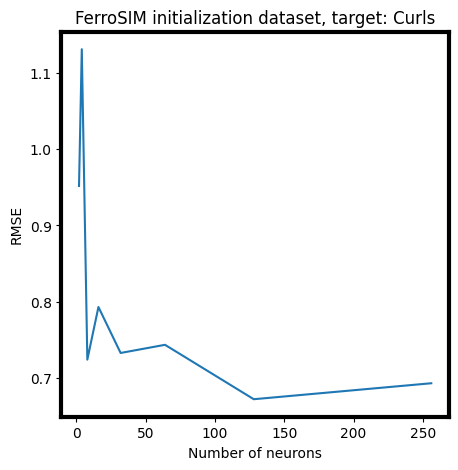

In [ ]:
fig, ax = plt.subplots(figsize = (5,5))
ax.plot([2,4,8,16,32,64,128,256], rmse_errors)
ax.set_xlabel('Number of neurons')
ax.set_ylabel('RMSE')
ax.set_title('FerroSIM initialization dataset, target: Curls')